In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['GDAL_SKIP'] = 'DODS'

import logging
import isce
root_logger = logging.getLogger()
root_logger.setLevel('WARNING')

# from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl
import ipyleaflet as ilfl
import ipywidgets as iwg
# from ipywidgets import GridspecLayout, AppLayout, VBox, HBox, HTML, Label

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon, box
from sklearn.neighbors import BallTree
import itertools

import requests
import boto3
import botocore
from datetime import datetime

from carst import SingleRaster, RasterVelos, ConfParams
from carst.libft import ampcor_task, writeout_ampcor_task
from carst.libxyz import ZArray, DuoZArray, AmpcoroffFile, points_in_polygon
import rasterio
from rasterio.plot import show

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [3]:
# ==== functions for constructing a polygon object for each LS8 frame

def check_crossing(lon_list):
    """
    Checks if the antimeridian is crossed.
    """
    return any(abs(pair[0] - pair[1]) > 180.0 for pair in itertools.combinations(lon_list, 2))

def gen_ls8_geometries(ls8_corner_pts_df):
    """
    Create a polygon object for each LS8 grid point. 
    If the polygon runs across the antimeridian, The polygon will be separated into two 
    adjacent polygons along the antimeridian, and these two polygons will be grouped into
    a single MultiPolygon object.
    """
    geometry_collection = []
    for index, row in ls8_corner_pts_df.iterrows():
        lon_list = [row.lon_UL, row.lon_UR, row.lon_LR, row.lon_LL]
        if check_crossing(lon_list):
            set1 = [x % 360.0 for x in lon_list]
            set2 = [x % -360.0 for x in lon_list]
            poly1 = Polygon([(set1[0], row.lat_UL), (set1[1], row.lat_UR), (set1[2], row.lat_LR), (set1[3], row.lat_LL)])
            poly2 = Polygon([(set2[0], row.lat_UL), (set2[1], row.lat_UR), (set2[2], row.lat_LR), (set2[3], row.lat_LL)])
            feature_geometry = MultiPolygon([poly1, poly2])
        else:
            feature_geometry = Polygon([(row.lon_UL, row.lat_UL), (row.lon_UR, row.lat_UR), (row.lon_LR, row.lat_LR), (row.lon_LL, row.lat_LL)])
        geometry_collection.append(feature_geometry)
    
    return geometry_collection

In [4]:
# Prepare LS8 corner data for query

ls8 = pd.read_excel('./LS8_cornerPts.xlsx')
geometry_collection = gen_ls8_geometries(ls8)
ls8_gdf = gpd.GeoDataFrame(ls8, geometry=geometry_collection)
ls8_gdf = ls8_gdf.drop(['lat_UL', 'lon_UL', 'lat_UR', 'lon_UR', 'lat_LL', 'lon_LL', 'lat_LR', 'lon_LR'], axis=1)
ls8_gdf

,path,row,lat_CTR,lon_CTR,geometry
0,1,1,80.774791,3.210620,"POLYGON ((5.42400 81.92300, 9.94700 80.30700, ..."
1,1,2,80.021757,-4.274059,"POLYGON ((-3.20700 81.20300, 2.30700 79.69900,..."
2,1,3,79.129883,-10.647337,"POLYGON ((-10.43200 80.32200, -4.40400 78.9360..."
3,1,4,78.130377,-16.029408,"POLYGON ((-16.40900 79.32000, -10.20700 78.048..."
4,1,5,77.048078,-20.572231,"POLYGON ((-21.35100 78.22700, -15.19300 77.061..."
...,...,...,...,...,...
57778,233,244,81.352691,28.155956,"POLYGON ((35.64600 81.84800, 30.97900 80.24500..."
57779,233,245,81.718750,18.566867,"POLYGON ((25.77700 82.38700, 22.59000 80.69100..."
57780,233,246,81.844418,8.404287,"POLYGON ((14.79400 82.68000, 13.57600 80.92900..."
57781,233,247,81.718750,-1.758293,"POLYGON ((3.34700 82.69600, 4.31400 80.94200, ..."


In [5]:
# ==== fuction for querying Path/Row number

def query_pathrow(point_geometry, polygon_data):
    '''
    Query the available LS8 Path/Row combinations for a given point in [lon, lat].
    We use a two-step process:
    (1) a ball tree search for all of the LS8 center points that are within 0.05 radians 
        (~2.85 degrees) from the query point.
    (2) a point-in-polygon search using the results from (1). 

    input:
        points_geometry: 2-element list showing [lon, lat]
        polygon_data: the LS8 GeoDataFrame object
    output:
        selection_idx: index numbers for the right Path/Row.
    '''
    
    # (1) Ball Tree
    points = np.vstack((polygon_data.lon_CTR.values, polygon_data.lat_CTR.values)).T
    points *= np.pi/180.
    LSBall = BallTree(points, metric='haversine')
    
    q = np.array(point_geometry)
    q *= np.pi/180.
    if type(point_geometry) is Point:
        pt = point_geometry
    else:
        pt = Point(point_geometry)
    
    pre_selection = LSBall.query_radius(q.reshape(1,-1), r=0.05, return_distance=False)
    pre_selection_idx = pre_selection[0]
    pre_selection_idx.sort()
    polygon_pre_selection = polygon_data.loc[pre_selection_idx]
    
    # (2) Point-in-polygon
    selection_idx = []
    for idx, row in polygon_pre_selection.iterrows():
        if pt.within(row.geometry):
            selection_idx.append(idx)
    
    return selection_idx

In [6]:
query_pt = [-50., 69.]
idx = query_pathrow(query_pt, ls8_gdf)
ls8_gdf.loc[idx]

,path,row,lat_CTR,lon_CTR,geometry
1747,8,12,68.279631,-49.545762,"POLYGON ((-50.91000 69.35600, -46.41400 68.660..."
1994,9,11,69.606373,-49.402408,"POLYGON ((-50.77700 70.69500, -46.05000 69.955..."
2242,10,11,69.606373,-50.947472,"POLYGON ((-52.32200 70.69500, -47.59500 69.955..."
20071,81,233,69.606373,-48.123782,"POLYGON ((-44.88600 69.19800, -49.35900 68.507..."
20319,82,233,69.606373,-49.668847,"POLYGON ((-46.43100 69.19800, -50.90400 68.507..."
20566,83,232,68.279631,-49.525493,"POLYGON ((-46.50100 67.84400, -50.76100 67.192..."
20567,83,233,69.606373,-51.213911,"POLYGON ((-47.97600 69.19800, -52.44900 68.507..."
20814,84,232,68.279631,-51.070557,"POLYGON ((-48.04600 67.84400, -52.30600 67.192..."


In [7]:
# !aws s3 ls s3://landsat-pds/c1/L8/217/015/ --no-sign-request

# STAC category is possible!!? (for sentinel-2)

def search_ls8_s3(ls8_gdf, pr_idx):
    s3_pathrow = '{:03d}/{:03d}'.format(ls8_gdf.loc[pr_idx].path, ls8_gdf.loc[pr_idx].row)
    s3_prefix = 'c1/L8/' + s3_pathrow + '/LC08_L1TP_'
    # print(s3_prefix)
    
    # according to https://github.com/boto/boto3/issues/1200
    s3 = boto3.client('s3', region_name='us-west-2', config=botocore.config.Config(signature_version=botocore.UNSIGNED))
    
    # https://towardsdatascience.com/working-with-amazon-s3-buckets-with-boto3-785252ea22e0
    response = s3.list_objects_v2(Bucket="landsat-pds", MaxKeys=1000, Prefix=s3_prefix, Delimiter='/')
    
    scene_list = pd.DataFrame(columns=('prefix', 'time', 'tier'))
    scene_idx = 0

    if response.get('CommonPrefixes') is None:
        # print('No available scenes!')
        pass
    else:
        for scene in response.get('CommonPrefixes'):
            scene_prefix = scene.get('Prefix')
            # print(scene.get('Prefix'))
            timestamp = scene_prefix.split('_')[3]
            timestamp = datetime.strptime(timestamp, '%Y%m%d')
            timestamp = timestamp.date()
            tierstate = scene_prefix.split('_')[6][:-1]
            # print(timestamp, tierstate)
            scene_list.loc[scene_idx] = [scene_prefix, timestamp,  tierstate]
            scene_idx += 1
    
    return s3_prefix, scene_list

In [13]:
def carst_featuretrack(file1_url, file1_date, file2_url, file2_date, inipath='param.ini'):
    ini = ConfParams(inipath)
    ini.ReadParam()
    ini.imagepair['image1'] = file1_url
    ini.imagepair['image2'] = file2_url
    ini.imagepair['image1_date'] = file1_date
    ini.imagepair['image2_date'] = file2_date
    ini.VerifyParam()
    a = SingleRaster(file1_url, date=file1_date)
    b = SingleRaster(file2_url, date=file2_date)
    if ini.pxsettings['gaussian_hp']:
        a.GaussianHighPass(sigma=ini.pxsettings['gaussian_hp_sigma'])
        b.GaussianHighPass(sigma=ini.pxsettings['gaussian_hp_sigma'])
    a.AmpcorPrep()
    b.AmpcorPrep()
    task = ampcor_task([a, b], ini)
    writeout_ampcor_task(task, ini)
    ampoff = AmpcoroffFile(ini.rawoutput['label_ampcor'] + '.p')
    ampoff.Load()
    ampoff.SetIni(ini)
    ampoff.FillwithNAN()   # fill holes with nan
    ampoff.Ampcoroff2Velo()
    ampoff.Velo2XYV(generate_xyztext=ini.rawoutput['if_generate_xyztext'])
    ampoff.XYV2Raster()

In [15]:
class itslive_api():
    # modified from https://github.com/nasa-jpl/itslive
    @staticmethod
    def get_granule_urls(params):
        '''
        params example:
        params = {'polygon': '-50.0783,69.6975,-50.0783,69.6995,-50.0763,69.6995,-50.0763,69.6975,-50.0783,69.6975', 
            'percent_valid_pixels': 1, 'start': '2017-08-29', 'end': '2019-03-31'}
        '''
        base_url = 'https://nsidc.org/apps/itslive-search/velocities/urls'
        resp = requests.get(base_url, params=params, verify=False)
        return resp.json()
    
    @staticmethod
    def get_minimal_bbox(query_pt):
        """
        a very rough approximation of a small bbox less than 1km of a given lon-lat point
        params: geometry, a geojson point geometry
        """
        lon = query_pt[0]
        lat = query_pt[1]
        lon_offset = -0.001 if lon < 0.0 else 0.001
        lat_offset = -0.001 if lat < 0.0 else 0.001

        bbox = box(lon - lon_offset, lat - lat_offset, lon + lon_offset, lat + lat_offset)
        coords = [[str(float("{:.4f}".format(coord[0]))),str(float("{:.4f}".format(coord[1])))] for coord in bbox.exterior.coords]
        coords = list(itertools.chain.from_iterable(coords))
        return ','.join(coords)
    
    def parse_urls(urls):
        '''
        parse urls
        '''
        pr_dict = {}
        for url_dict in urls:
            file_name = os.path.basename(url_dict['url'])
            # LC08_L1TP_009011_20181002_20181010_01_T1_X_LC08_L1GT_009011_20180308_20180308_01_RT_G0240V01_P036.nc
            file_components = file_name.split('_')
            prstr = file_components[2]
            prstr = prstr[:3] + '/' + prstr[-3:]
            start_date = datetime.strptime(file_components[11], "%Y%m%d").date()
            end_date = datetime.strptime(file_components[3], "%Y%m%d").date()
            pair_days = end_date - start_date
            img1_tier = file_components[14]
            img2_tier = file_components[6]
            if img1_tier != 'RT' and img2_tier != 'RT':      # For now let's show results using T1 images only
                if prstr == '083/232':
                    print(url_dict['url'])
                start_date_str = start_date.strftime('%Y-%m-%d')
                end_date_str = end_date.strftime('%Y-%m-%d')
                entrystr = ' / '.join((start_date_str, end_date_str, f'{pair_days.days} days'))
                if prstr in pr_dict:
                    pr_dict[prstr].append(entrystr)
                else:
                    pr_dict[prstr] = [entrystr]
        
        for key in pr_dict:
            pr_dict[key].sort()
        return pr_dict
            
            
#         mid_date = start_date + (end_date - start_date) / 2

#         coverage = {
#             'url': url,
#             'start': start_date,
#             'end': end_date,
#             'mid_date': mid_date
#         }
#         return coverage

    

In [16]:
# Adapted from Alice's AGU talk
zoom = 4
mainmap = ilfl.Map(basemap=ilfl.basemaps.Gaode.Satellite, center=[query_pt[-1], query_pt[0]], zoom=zoom)

mker = ilfl.Marker(location=[query_pt[-1], query_pt[0]], draggable=True)
mainmap.add_layer(mker)

pr_options = [('{:03d}/{:03d}'.format(ls8_gdf.loc[i, 'path'], ls8_gdf.loc[i, 'row']) ,i) for i in idx]
pr_menu = iwg.Select(options=pr_options, description='Path/Row:', rows=15)
pr_scene_options = []
pr_scene_menu = iwg.SelectMultiple(options=pr_scene_options, description='Available dates:', rows=20)
pr_kernel_selection = iwg.RadioButtons(options=['ITS_LIVE (online ready)', 'CARST'], value='ITS_LIVE (online ready)', description='Dataset / Kernel:')
pr_scene_button = iwg.Button(description='Search for dates')


band_radiobuttons = iwg.RadioButtons(options=['B4', 'B8'], value='B8', description='Band:')
ft_start_button = iwg.Button(description='Start feature tracking')

pr_selection = idx[0]
pr_scene_list = pd.DataFrame(columns=('prefix', 'time', 'tier'))
pr_polygon = ilfl.WKTLayer(wkt_string=ls8_gdf.loc[pr_selection].geometry.wkt)
mainmap.add_layer(pr_polygon)

# ==== map marker callback

def on_location_changed(event):
    global query_pt, idx
    query_pt = [mker.location[-1], mker.location[0]]
    idx = query_pathrow(query_pt, ls8_gdf)
    pr_options_new = [('{:03d}/{:03d}'.format(ls8_gdf.loc[i, 'path'], ls8_gdf.loc[i, 'row']) ,i) for i in idx]
    pr_menu.options = pr_options_new

mker.observe(on_location_changed, 'location')

# ==== left side menu selection callback

def on_menu_selection_changed(change):
    global pr_selection
    pr_selection = change['new']
    pr_polygon.wkt_string=ls8_gdf.loc[pr_selection].geometry.wkt

pr_menu.observe(on_menu_selection_changed, names='value')

# ==== search button click callback

output = iwg.Output()
def on_searchbutton_clicked(b):
    global pr_scene_list
    with output:
        if pr_kernel_selection.value == 'CARST':
            s3_prefix, pr_scene_list = search_ls8_s3(ls8_gdf, pr_selection)
            # print(s3_prefix)
            pr_scene_menu.options = [(record['time'], idx) for idx, record in pr_scene_list.loc[pr_scene_list['tier'] == 'T1'].iterrows()]
        elif pr_kernel_selection.value == 'ITS_LIVE (online ready)':
            query_pt = [mker.location[-1], mker.location[0]]
            polygon_coords = itslive_api.get_minimal_bbox(query_pt)
            params = {'polygon': polygon_coords, 'percent_valid_pixels': 1, 'start': '2015-01-01', 'end': '2020-01-01'}
            urls = itslive_api.get_granule_urls(params)
            pr_dict = itslive_api.parse_urls(urls)
            pr_dict_key = '{:03d}/{:03d}'.format(ls8_gdf.loc[pr_selection, 'path'], ls8_gdf.loc[pr_selection, 'row'])
            pr_scene_menu.options = pr_dict[pr_dict_key]
            
pr_scene_button.on_click(on_searchbutton_clicked)

# ==== feature tracking button click callback

file1_url  = None 
file1_date = None 
file2_url  = None 
file2_date = None

def on_ftbutton_clicked(ft):
    global file1_url, file1_date, file2_url, file2_date
    with output:
        selected_list = pr_scene_list.loc[list(pr_scene_menu.value)]
        selected_list_prefix = selected_list['prefix'].tolist()
        selected_list_time = selected_list['time'].tolist()
        file1_url = 'https://landsat-pds.s3.amazonaws.com/' + selected_list_prefix[0] + os.path.basename(selected_list_prefix[0][:-1]) + '_' + band_radiobuttons.value + '.TIF'
        file2_url = 'https://landsat-pds.s3.amazonaws.com/' + selected_list_prefix[1] + os.path.basename(selected_list_prefix[1][:-1]) + '_' + band_radiobuttons.value + '.TIF'
        file1_date = selected_list_time[0].strftime('%Y-%m-%d')
        file2_date = selected_list_time[1].strftime('%Y-%m-%d')
        print(file1_url, file1_date, file2_url, file2_date)
        carst_featuretrack(file1_url, file1_date, file2_url, file2_date)

ft_start_button.on_click(on_ftbutton_clicked)



leftside = iwg.VBox([iwg.HTML("<h2>Drag the marker to your region of interest</h1>"), pr_menu, pr_kernel_selection, pr_scene_button])
leftside.layout.align_items = 'center'

rightside = iwg.VBox([pr_scene_menu, band_radiobuttons, ft_start_button])
rightside.layout.align_items = 'center'

iwg.AppLayout(left_sidebar=leftside, center=mainmap, right_sidebar=rightside)


AppLayout(children=(VBox(children=(HTML(value='<h2>Drag the marker to your region of interest</h1>'), Select(d…

In [13]:
output

Output(outputs=({'name': 'stdout', 'text': 'https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_00901…

In [11]:
print(file1_url, file1_date, file2_url, file2_date)

https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20180916_20180928_01_T1/LC08_L1TP_009011_20180916_20180928_01_T1_B8.TIF 2018-09-16 https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20181002_20181010_01_T1/LC08_L1TP_009011_20181002_20181010_01_T1_B8.TIF 2018-10-02


In [12]:
# carst_featuretrack(file1_url, file1_date, file2_url, file2_date)

In [13]:
mker.location

[69.0, -50.0]

In [11]:
pr_kernel_selection.value

'ITS_LIVE (online ready)'

In [38]:
'{:03d}/{:03d}'.format(ls8_gdf.loc[pr_selection, 'path'], ls8_gdf.loc[pr_selection, 'row'])


'008/012'

In [35]:
query_pt = [mker.location[-1], mker.location[0]]
polygon_coords = itslive_api.get_minimal_bbox(query_pt)
params = {'polygon': polygon_coords, 'percent_valid_pixels': 1, 'start': '2018-01-01', 'end': '2020-01-01'}
urls = itslive_api.get_granule_urls(params)
itslive_api.parse_urls(urls)

/home/whyj/anaconda3/envs/carst/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nsidc.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/whyj/anaconda3/envs/carst/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nsidc.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32623/LC08_L1TP_083232_20180619_20180703_01_T1_X_LC08_L1TP_083232_20170718_20170727_01_T1_G0240V01_P040.nc
http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_083232_20180619_20180703_01_T1_X_LC08_L1TP_083232_20170718_20170727_01_T1_G0240V01_P039.nc


{'009/011': ['2018-03-08 / 2018-10-02 / 208 days',
  '2017-08-12 / 2018-10-18 / 432 days',
  '2017-10-15 / 2018-03-24 / 160 days',
  '2017-10-15 / 2018-05-27 / 224 days',
  '2017-07-27 / 2018-06-12 / 320 days',
  '2017-07-27 / 2018-08-15 / 384 days',
  '2017-08-12 / 2018-08-15 / 368 days',
  '2018-03-24 / 2018-08-15 / 144 days',
  '2017-05-24 / 2018-09-16 / 480 days',
  '2018-04-25 / 2018-09-16 / 144 days',
  '2017-08-12 / 2018-10-02 / 416 days',
  '2018-08-15 / 2018-10-18 / 64 days',
  '2017-05-24 / 2018-11-03 / 528 days',
  '2017-07-27 / 2018-11-03 / 464 days',
  '2018-04-25 / 2018-11-03 / 192 days',
  '2018-08-15 / 2018-11-03 / 80 days',
  '2017-04-22 / 2018-09-16 / 512 days',
  '2017-05-24 / 2018-11-03 / 528 days',
  '2017-07-11 / 2018-11-03 / 480 days',
  '2017-07-27 / 2018-11-03 / 464 days',
  '2017-08-12 / 2018-11-03 / 448 days',
  '2017-10-15 / 2018-11-03 / 384 days',
  '2017-10-31 / 2018-11-03 / 368 days',
  '2017-05-24 / 2018-08-15 / 448 days',
  '2018-04-09 / 2018-08-15 / 12

http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32623/LC08_L1TP_083232_20180619_20180703_01_T1_X_LC08_L1TP_083232_20170718_20170727_01_T1_G0240V01_P040.nc
http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32622/LC08_L1TP_083232_20180619_20180703_01_T1_X_LC08_L1TP_083232_20170718_20170727_01_T1_G0240V01_P039.nc

In [29]:
# LC08_L1TP_009011_20181002_20181010_01_T1_X_LC08_L1GT_009011_20180308_20180308_01_RT_G0240V01_P036.nc
tmp = urls[0]['url']
# tmp.split('/')[-1].replace('.nc', '')
file_name = os.path.basename(tmp)
file_components = file_name.split('_')
start_date = datetime.strptime(file_components[3], "%Y%m%d").date()
end_date = datetime.strptime(file_components[4], "%Y%m%d").date()
mid_date = start_date + (end_date - start_date) / 2
end_date

datetime.date(2018, 10, 10)

In [100]:
# response = s3.list_objects_v2(Bucket="landsat-pds", MaxKeys=1000, Prefix='c1/L8/009/011/LC08_L1TP_009011_20200703_20200708_01_T1/LC08_L1TP_009011_20200703_20200708_01_T1_B4.TIF')
# for record in response['Contents']:
#     if record['Key'].endswith('.TIF'):
#         file1 = 'https://landsat-pds.s3.amazonaws.com/' + record['Key']
        
# response = s3.list_objects_v2(Bucket="landsat-pds", MaxKeys=1000, Prefix='c1/L8/009/011/LC08_L1TP_009011_20200820_20200905_01_T1/LC08_L1TP_009011_20200820_20200905_01_T1_B4.TIF')
# for record in response['Contents']:
#     if record['Key'].endswith('.TIF'):
#         file2 = 'https://landsat-pds.s3.amazonaws.com/' + record['Key']
        
# print(file1, file2)

In [15]:
a = SingleRaster(file1_url, date=file1_date)
b = SingleRaster(file2_url, date=file2_date)
if ini.pxsettings['gaussian_hp']:
    a.GaussianHighPass(sigma=ini.pxsettings['gaussian_hp_sigma'])
    b.GaussianHighPass(sigma=ini.pxsettings['gaussian_hp_sigma'])
a.AmpcorPrep()
b.AmpcorPrep()

Calling gdalbuildvrt...
gdalbuildvrt LC08_L1TP_009011_20180916_20180928_01_T1_B8_GHP-3.0sig.tif.vrt LC08_L1TP_009011_20180916_20180928_01_T1_B8_GHP-3.0sig.tif
Calling gdalbuildvrt...
gdalbuildvrt LC08_L1TP_009011_20181002_20181010_01_T1_B8_GHP-3.0sig.tif.vrt LC08_L1TP_009011_20181002_20181010_01_T1_B8_GHP-3.0sig.tif


In [14]:
inipath = 'param.ini'
ini = ConfParams(inipath)
ini.ReadParam()
ini.imagepair['image1'] = file1_url
ini.imagepair['image2'] = file2_url
ini.imagepair['image1_date'] = file1_date
ini.imagepair['image2_date'] = file2_date
ini.VerifyParam()

In [16]:
task = ampcor_task([a, b], ini)
writeout_ampcor_task(task, ini)

Scale Factor in Range: Scale Factor in Range: Scale Factor in Range:    Scale Factor in Range: 1.0 Scale Factor in Range: 1.01.0


1.0Scale Factor in Azimuth: Scale Factor in Range:  Scale Factor in Azimuth: Scale Factor in Range: 
 Scale Factor in Azimuth:    1.0Scale Factor in Azimuth:  1.0 1.01.01.0

1.0

Scale Factor in Azimuth: Skip Sample Down: 16

Scale Factor in Azimuth: Skip Sample Down: 161.0 
Scale Factor in Azimuth:  Skip Sample Down: 16

1.01.0
Skip Sample Down: 16

Skip Sample Across: 16Skip Sample Across: 16Skip Sample Across: 16Skip Sample Down: 16 Skip Sample Down: 16



1.0Skip Sample Across: 16Skip Sample Across: 16Skip Sample Across: 16





Skip Sample Down: 16
Skip Sample Across: 16
Scale Factor in Range:  1.0
Scale Factor in Azimuth:  1.0
Skip Sample Down: 16
Skip Sample Across: 16


In [17]:
ampoff = AmpcoroffFile(ini.rawoutput['label_ampcor'] + '.p')
ampoff.Load()
ampoff.SetIni(ini)
ampoff.FillwithNAN()   # fill holes with nan
ampoff.Ampcoroff2Velo()
ampoff.Velo2XYV(generate_xyztext=ini.rawoutput['if_generate_xyztext'])
ampoff.XYV2Raster()

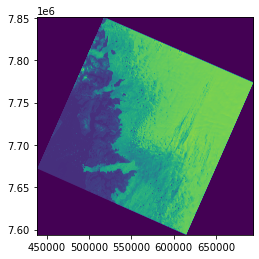

<AxesSubplot:>

In [35]:
file1_url = 'https://landsat-pds.s3.amazonaws.com/c1/L8/009/011/LC08_L1TP_009011_20200703_20200708_01_T1/LC08_L1TP_009011_20200703_20200708_01_T1_B4.TIF'
dataset = rasterio.open(file1_url)
show(dataset)

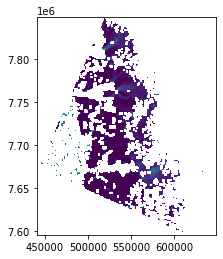

<AxesSubplot:>

In [12]:
dataset = rasterio.open('20200703-20200820_velo-raw_mag.tif')
show(dataset)

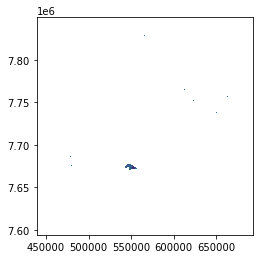

<AxesSubplot:>

In [19]:
dataset = rasterio.open('20180916-20181002_velo-raw_mag.tif')
show(dataset)